## Top 4%

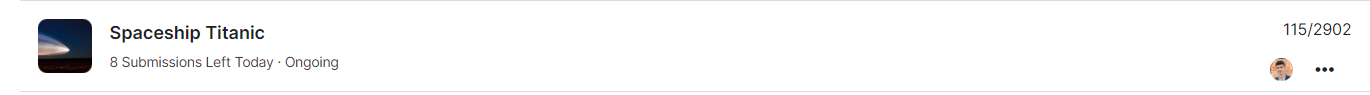

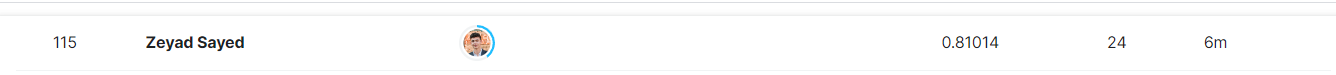

# Import

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [23]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Clean Data

In [24]:
df.fillna(method='ffill', inplace=True)

# Cap RoomService at 9000
df.loc[df.RoomService.gt(9000), 'RoomService'] = 9000

# Cap FoodCourt at 22000
df.loc[df.FoodCourt.gt(22000), 'FoodCourt'] = 22000

# Cap ShoppingMall at 11000
df.loc[df.ShoppingMall.gt(11000), 'ShoppingMall'] = 11000

# Cap Spa at 17000
df.loc[df.Spa.gt(17000), 'Spa'] = 17000

# Cap VRDeck at 21000
df.loc[df.VRDeck.gt(21000), 'VRDeck'] = 21000


df['HomePlanet'] = df['HomePlanet'].replace({'Europa':0, 'Earth':1, 'Mars':2})
df['CryoSleep'] = df['CryoSleep'].astype(bool).astype(int)
df['VIP']=df['VIP'].astype(bool).astype(int)
df['Transported'] = df['Transported'].astype(bool).astype(int)
df['Sector']=df['Cabin'].str.split('/',expand=True)[0]
df['Wing']=df['Cabin'].str.split('/',expand=True)[2]
df['Wing']=df['Wing'].replace({'P':0, 'S':1})
df['Sector'] = df['Sector'].replace({'B':0, 'F':1, 'A':2, 'G':3, 'E':4, 'C':5, 'D':6, 'T':7})
df['Destination'] = df['Destination'].replace({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2})

df.drop(columns=['Name','PassengerId','Cabin'],inplace=True)

# Model

In [25]:
target ='Transported'
X = df.drop(columns=target)
y = df[target]

In [26]:
y_pred_baseline = df['Transported'].value_counts(normalize=True).max()
y_pred_baseline

0.5036236051995858

In [27]:
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from catboost import CatBoostClassifier
'''
# Define model


 # Define parameters' grid
grid = {'verbose': [False],
         'thread_count': [-1],
         'depth': [4, 5, 6, 7],
         'iterations': [1000, 2000, 3000, 5000],
         'learning_rate': [0.001, 0.005, 0.01, 0.02]}

# Define GridSearchCV
grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
grid_cat.fit(X, y)

params = grid_cat.best_params_

print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best parameters:\n', params)'''

"\n# Define model\n\n\n # Define parameters' grid\ngrid = {'verbose': [False],\n         'thread_count': [-1],\n         'depth': [4, 5, 6, 7],\n         'iterations': [1000, 2000, 3000, 5000],\n         'learning_rate': [0.001, 0.005, 0.01, 0.02]}\n\n# Define GridSearchCV\ngrid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)\ngrid_cat.fit(X, y)\n\nparams = grid_cat.best_params_\n\nprint('\n Best Score:\n', grid_cat.best_score_)\nprint('\n Best parameters:\n', params)"

In [28]:
Best_parameters =  {'depth': 7, 'iterations': 1000, 'learning_rate': 0.02, 'thread_count': -1, 'verbose': False}

In [29]:
# Define and fit the final model

from sklearn.preprocessing import StandardScaler
sd = StandardScaler()
X = sd.fit_transform(X)

cat_model = CatBoostClassifier(**Best_parameters)
cat_model.fit(X, y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X, y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

count    5.000000
mean     0.798346
std      0.013300
min      0.779758
25%      0.791259
50%      0.802647
75%      0.803335
max      0.814730
dtype: float64

    Feature Id  Importances
0          10    14.067062
1           0    13.842080
2           8    12.700711
3           9    10.862297
4           1     9.682408
5           5     9.027801
6           6     8.227778
7           3     7.988228
8           7     5.766090
9          11     4.486887
10          2     3.137844
11          4     0.210812


## Evaluate

<Figure size 1000x600 with 0 Axes>

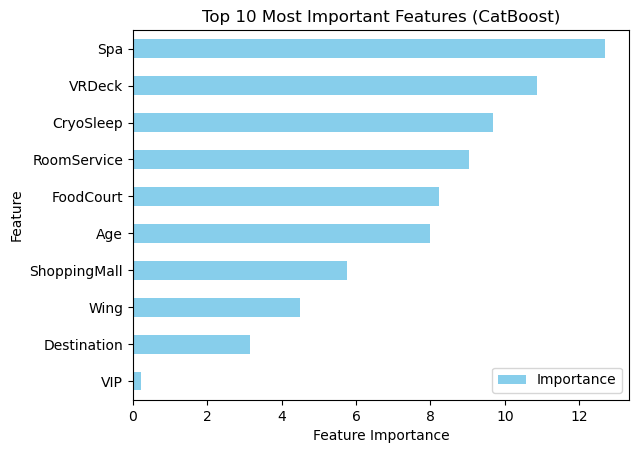

In [33]:
# Get feature importance
feature_importance = cat_model.get_feature_importance(type='FeatureImportance')

# Create a Pandas DataFrame with feature names and their importance scores
feat_importance_df = pd.DataFrame({'Feature': df.drop(columns='Transported').columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values in descending order
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=1)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
feat_importance_df.head(10).plot(x='Feature', y='Importance', kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features (CatBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# Predict on the test file

In [34]:
test['HomePlanet'] = test['HomePlanet'].replace({'Europa':0, 'Earth':1, 'Mars':2})
test['CryoSleep'] = test['CryoSleep'].astype(bool).astype(int)
test['VIP']=test['VIP'].astype(bool).astype(int)
test['Sector']=test['Cabin'].str.split('/',expand=True)[0]
test['Wing']=test['Cabin'].str.split('/',expand=True)[2]
test['Wing']=test['Wing'].replace({'P':0, 'S':1})
test['Sector'] = test['Sector'].replace({'B':0, 'F':1, 'A':2, 'G':3, 'E':4, 'C':5, 'D':6, 'T':7})
test['Destination']= test['Destination'].replace({'TRAPPIST-1e':0, 'PSO J318.5-22':1, '55 Cancri e':2})
test.drop(columns=['Name','PassengerId','Cabin'],inplace=True)
sd = StandardScaler()
test = sd.fit_transform(test)

In [35]:
pred = cat_model.predict(test)

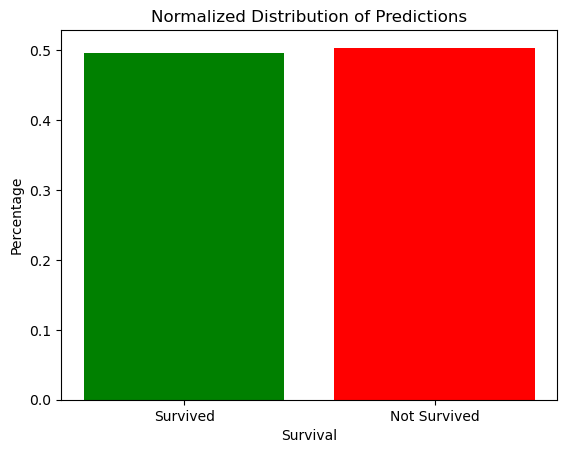

In [36]:
import numpy as np
survived_count = np.sum(pred == 1)
not_survived_count = np.sum(pred == 0)

total_predictions = len(pred)

# Normalize counts
survived_percentage = survived_count / total_predictions
not_survived_percentage = not_survived_count / total_predictions

# Create a bar plot
labels = ['Survived', 'Not Survived']
values = [survived_percentage, not_survived_percentage]

plt.bar(labels, values, color=['green', 'red'])
plt.title('Normalized Distribution of Predictions')
plt.xlabel('Survival')
plt.ylabel('Percentage')
plt.show()

# Submission

Text(0.5, 1.0, 'Prediction distribution')

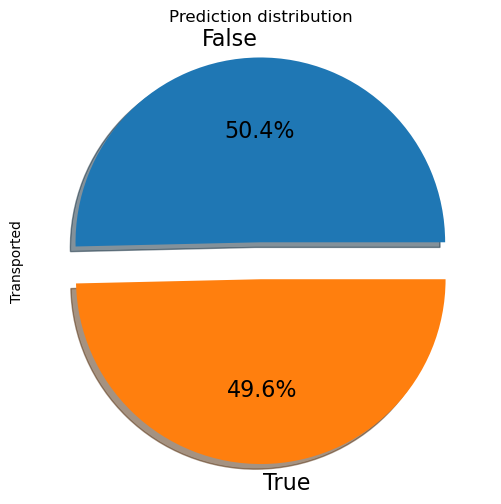

In [37]:
# Sample submission (to get right format)
sub=pd.read_csv('sample_submission.csv')

# Add predictions
sub['Transported']=pred

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [38]:
# Output to csv
sub.to_csv('submission.csv', index=False)